In [2]:
from IPython.display import Math, HTML
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default'></script>"))

## Présentation du problème 

Dans le problème du voyageur de commerce, on souhaite minimiser le coût du trajet entre M villes sous contrainte de passer seulement une fois par chacune des villes. 

Une solution naïve à notre problème serait de faire l'ensemble des combinaisons possibles entre les M villes et de prendre le chemin le moins coûteux. Cependant,
la complexité (M!) et le coup en calculs seraient trop élevés. De ce fait, il apparait intéressant de trouver des algorithmes plus efficaces.

In [1]:
#Import des constantes
import numpy as np
import time
from scipy.stats import rankdata
import itertools
import matplotlib.pyplot as plt
import geopy
import math
import random
from geopy.distance import geodesic
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import copy
np.random.seed(2)

In [0]:
!pip install tsp_solver2

In [27]:
from tsp_solver.greedy import solve_tsp

In [28]:
big_699 = np.loadtxt('699.txt')
big_10628 = np.loadtxt('10628.txt')
big_937 = np.loadtxt('937.txt')

# 1. Question 1

**Question** : 

Rappeler (ou retrouver!) la méthode permettant de simuler efficacement N vecteurs selon la loi Multinomiale définie par le vecteur de probabilité 
$p =(p_1, . . . , p_M)$
La mettre en oeuvre.



Nous avons cherché tout d'abord à simuler N vecteurs selon la loi Multinomiale selon deux méthodes différentes afin de définir notre statistique d'ordre, i.e. l'ordre de passage du voyageur dans les M villes. Nous proposons pour cela deux méthodes.

**Méthode naïve** : 

- Définir M valeurs $p_{i}$ avec $\sum_{m = 1}^{M}p_{m} = 1$
- Générer n $U_{i} \sim \mathrm{U}[0,1]$
- Définir le vecteur "cumulatif" défini comme : $Vect = [0,p_{1},p_{1}+p_{2},...,\sum_{m = 1}^{M}p_{m}]$
- Sommer le nombre de $U_{i} \in [Vect[k], Vect[k+1]]$ pour $k \in [0,M-1]$



La complexité de cette méthode est un $O(NM)$ (pour chaque loi simulée, on effectue un $O(M)$ comparaisons).

In [3]:
#generation of N multinomial method 1
def multi(parameters, N, n):
    """Parameters is a vector of parameters of the multinomial law
     N is the number of multinomial realisation simulated
     n is the number of uniforms simulated for each multinomial realisation"""
    t = time.time()
    res = []
    vect_bis = np.cumsum(parameters)
    for k in range(N):
        u = np.random.rand(n)
        aux = [sum((u <= vect_bis[0]))]
    for i in range(1, len(parameters)):
        aux.append(sum((u <= vect_bis[i]) & (u >= vect_bis[i-1])))
    res.append(aux)
    t = time.time() - t
    return res,t

On peut visualiser les résultats à l'aide d'un histogramme (qui doit converger vers le vecteur de paramètres $p$ pour un nombre $N$ de vecteurs générés important). Nous avons également tracé les temps mis par la méthode en fonction du nombre $N$ de vecteurs générés ainsi que de la taille $M$ des vecteurs.

C:\Users\mehdi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


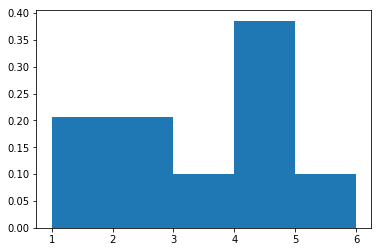

In [5]:
#check results
points = multi([0.2,0.2,0.1,0.4,0.1],1,10000)[0] #on peut faire varier n pour voir comment ça s'arrange bien
histogr = []
for k in range(5):
    histogr = histogr + [k+1]*points[0][k]
plt.hist(histogr, bins = [1,2,3,4,5,6], normed = True)
plt.show()

Pour $n$ suffisamment grand, on observe que le vecteur aléatoire tiré est pratiquement égal au vecteur $p$, ce qui correspond bien au comportement d'une loi multinomiale.

In [0]:
#visualize performance

#computing time for different N
Nombre_iter_N = [1,10,100,1000,10000,100000]

##M=2
Times_2 = []
for N in Nombre_iter_N:
    t = multi([0.4,0.6], N, 1000)[1]
    Times_2.append(t)
    
##M=8
Times_8 = []
for N in Nombre_iter_N:
    t = multi([0.05,0.1,0.05,0.1,0.25,0.15,0.2,0.1], N, 1000)[1]
    Times_8.append(t)

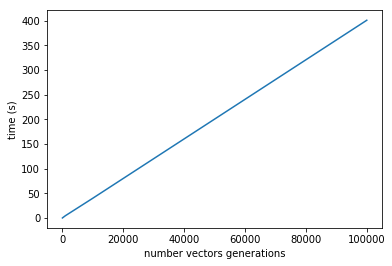

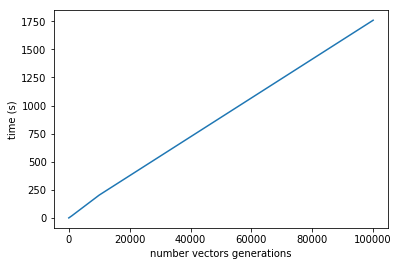

In [0]:
#results 
Nombre_iter_N = [1,10,100,1000,10000,100000]

##M=2
Times_2 = [0.012231826782226562, 0.08855271339416504, 0.4621725082397461, 4.579376459121704, 40.04317378997803, 401.21809363365173]
plt.plot(Nombre_iter_N, Times_2)
plt.xlabel('number vectors generations')
plt.ylabel('time (s)')
plt.show()

##M=8
Times_8 = [0.04864001274108887, 0.17108798027038574, 1.8088700771331787, 18.844942092895508, 203.24580311775208, 1759.0445971488953]
plt.plot(Nombre_iter_N, Times_8)
plt.xlabel('number vectors generations')
plt.ylabel('time (s)')
plt.show()

On observe bien une évolution quasi-linéaire du temps de la méthode en fonction du paramètre N à M fixé. En faisant varié M, on observe que la pente de la droite augmente, ce qui confirme la complexité en $O(NM)$. Notons que pour génerer 100000 vecteurs selon une loi multinomiale de taille 8, la méthode prend environ 29 minutes , ce qui commence à être conséquent.

**Méthode sophistiquée** (processus de Poisson) :

Nous reprenons la méthode précedente mais en génerant les n lois uniformes $\mathrm{U}[0,1]$ triées. On  procède de la manière suivante :

- Tirer $N+1$ lois exp(1) $E_{1},...,E_{N+1}$
- Calculer $V_{1:N+1} = CumSum(E_{1:(N+1)})$
- Déterminer le vecteur $(\frac{V_{1}}{V_{N+1}},..., \frac{V_{N}}{V_{N+1}})$

L' avantage de renvoyer n lois unifromes triées est de pouvoir accélerer grandement l'étape "Sommer les observations appartenant à chaque intervalle". En effet, une fois l'appartenance d'une uniforme définie, il n'est pas utile de regarder les intervalles qui précèdent pour l'uniforme suivante. Le complexité devient alors un $O(M+N)$ (après avoir tirer $N+1$ lois uniformes triées en $O(N)$, il reste à faire un $O(M)$ comparaisons).

In [4]:
#generation of uniform
def unif_ord(n):
    """n is the number of uniforms generated
    Return the vector of ordered proportions"""
    u = np.random.rand(n + 1)
    e = np.log(1 / (1-u))
    v = np.cumsum(e)
    vn1 = v[-1]
    return np.array(v[:-1])/vn1


#generation of N multinomial method 2
def multi2(parameters, N, n):
    """Parameters is a vector of parameters of the multinomial law
     N is the number of multinomial realisation simulated
     n is the number of uniforms simulated for each multinomial realisation"""
    t = time.time()
    res = []
    vect_bis = np.cumsum(parameters)
    for k in range(N):
        u = unif_ord(n)
        aux = [0 for k in range(len(parameters))]
        aux[0] = sum((u <= vect_bis[0]))
        i = aux[0]
        for indice in range(1, len(vect_bis)) :
            while (i < n) and (u[i] <= vect_bis[indice]) and (u[i] > vect_bis[indice-1]):
                aux[indice] += 1
                i += 1
        res.append(aux)
    t = time.time() - t
    return res,t

De même que précedemment, on vérifie les résultats renvoyés ainsi que la performance de la méthode  :

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


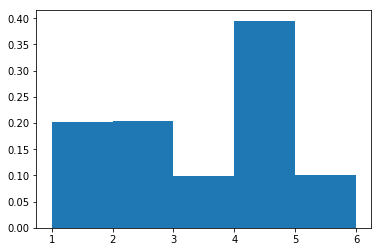

In [0]:
#check results

points = multi2([0.2,0.2,0.1,0.4,0.1],1,10000)[0] 
histogr = []
for k in range(5):
    histogr = histogr + [k+1]*points[0][k]
plt.hist(histogr, bins = [1,2,3,4,5,6], normed=True)
plt.show()

Pour n suffisamment grand, on observe de même que le vecteur aléatoire tiré est pratiquement égal au vecteur $p$.

In [0]:
#visualize performance

#computing time for different N

##M=2
Nombre_iter_N = [1,10,100,1000,10000,100000]
Times2_2 = []
for N in Nombre_iter_N:
    print(N)
    t = multi2([0.4,0.6], N, 1000)[1]
    Times2_2.append(t)

##M=8
Nombre_iter_N = [1,10,100,1000,10000,100000]
Times2_8 = []
for N in Nombre_iter_N:
    print(N)
    t = multi2([0.05,0.1,0.05,0.1,0.25,0.15,0.2,0.1], N, 1000)[1]
    Times2_8.append(t)

1
10
100
1000
10000
100000
1
10
100
1000
10000
100000


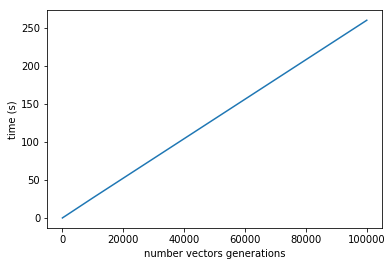

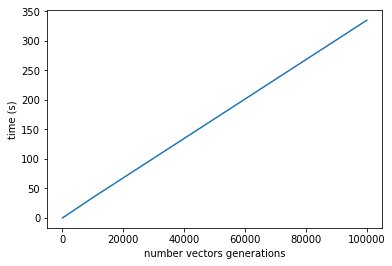

In [0]:
##results 
Nombre_iter_N = [1,10,100,1000,10000,100000]

##M=2
Times2_2 = [0.009679555892944336, 0.05167818069458008, 0.30654072761535645, 2.621734142303467, 26.40952467918396, 260.36765003204346]
plt.plot(Nombre_iter_N,Times2_2)
plt.xlabel('number vectors generations')
plt.ylabel('time (s)')
plt.show()

##M=8
Times2_8 = [0.0055942535400390625, 0.04038810729980469,0.3478851318359375, 3.2890686988830566, 34.546205282211304,335.1734371185303]
plt.plot(Nombre_iter_N,Times2_8)
plt.xlabel('number vectors generations')
plt.ylabel('time (s)')
plt.show()

De même que précedemment, on observe une croissance du temps t quasi-linéaire en  N . Cependant, en faisant varier le parmaètre  M , le temps mis par l'algorithme n'est pas sensiblement augmenté. Ce qui confirme la complexité en  O(N+M) .

In [10]:
%time numpy_sim = np.random.multinomial(20, [1/6.]*6, size=100000)

Wall time: 57.1 ms


In [11]:
%time our_sim = multi2([1/6.]*6, 100000, 20)

Wall time: 8.24 s


Si on compare notre implémentation par rapport à celle de numpy, on constate que numpy est beaucoup plus rapide. Cela est probablement dû à la boucle implémentée dans notre code, en effet ces opérations étant indépendantes elles pourraient être fait en même temps.

# 2. Question 2

**Question** :
Utiliser l’algorithme CE vu en cours pour résoudre le problème TSP. Pour ce faire, proposer
une famille paramétrique de lois pour la simulation de trajets. 
Programmer cet algorithme, et le tester sur quelques exemples

Nous considérons une famille paramétrique { $M_p$ , $p \in $ {$ u, u\in \mathbb{R}_+^{M}$,  $||u||_{1}=1$} }.

De manière générale **l'algorithme CE (Cross-Entropy)** fonctionne selon les étapes suivantes :
- Initialiser $p=p_0$

- Génerer un échantillon de taille $n$ selon la loi $M_{p_{t}}$ 

- Sélectionner, sur cet échantillon, les chemins dont les coûts sont minimums (les 10% de plus faible coût)

- Estimer par MLE le paramètre d'intérêt sur ce sous-échantillon

 


 
   La première étape la génération de route. Une route étant définie comme une permutation de  {1, $\dots$ , n}.
   Nous proposons **deux méthodes** : 
   
   1) Une idée qui nous est propre 
   
   2) Une piste issue du Chapitre 4 du livre “The Cross-Entropy Method” de Rubinstein et Kroese.
 
 


  

## 2.1 Fonctions préliminaires 

On commence par créer deux fonctions qui serviront respectivement à générer une matrice de coût aléatoire et à calculer le coût associé à un chemin étant donné cette matrice. On implémente aussi une fonction qui calcule le coût minimal possible par force brute en essayant toutes les possibilités (*bien sûr on ne l'utilisera que pour les petits problèmes*).

In [5]:
def create_matrix(m):
    """m is an int
    Function returns a random symetric matrix of size (m,m) such that d[i,i]=0"""
    d = np.random.randint(1,1000,(m,m))
    d = (d+d.T)/2
    for i in range(m):
        d[i,i] = 0
    return d

def cost(route, m):
    """m is the distance matrix of shape (M,M)
       route is an array of list of length M giving the route to follow
       function returns the total cost of the route given the distance matrix"""
    c=0
    for i in range(len(route)-1):
        c += m[route[i], route[i+1]]
    c += m[route[-1], route[0]]
    return c
  
def min_cost(D):
    """Computes minimal cost by testing for all possibilities 
    D : cost matrix
    DO NOT DO IT WITH LARGE MATRICES"""
    pe = list(itertools.permutations([i for i in range(D.shape[0])]))  
    all_cost = []     
    for perm in pe :
        all_cost.append(cost(perm, D))
    return min(all_cost)

On code aussi deux fonctions qui serviront pour la visualisations des résultats.

In [6]:
def viz_matrix(mat):
    """ mat : matrix in the form of a numpy array
    Function returns a 3D plot of the cells' values"""
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(30, 45)
    lx = len(mat[0])        
    ly = len(mat[:,0])
    xpos = np.arange(0,lx,1)    
    ypos = np.arange(0,ly,1)
    xpos, ypos = np.meshgrid(xpos+0.25, ypos+0.25)
    xpos = xpos.flatten()   
    ypos = ypos.flatten()
    zpos = np.zeros(lx*ly)
    dx = 0.5 * np.ones_like(zpos)
    dy = dx.copy()
    dz = mat.flatten()
    ax.bar3d(xpos,  ypos, zpos, dx, dy, dz)
    ax.set_zlabel('Probability')
    plt.show()
    return None
    

def viz_convergence(cout_emp, std, cout_th=None):
    """cout_emp is a list of empirical costs
     cout_th is the minimal theoritical cost if known
     std is the list of standard deviation
     Function returns a plot of the evolution of cout_emp"""
    if cout_th == None :
        plt.figure(figsize = (10,8))
        time = [i for i in range(len(std))] 
        #plt.plot(cout_emp, alpha=0.5, label="Mean cost of generated routes")
        plt.errorbar(time, cout_emp, std, linestyle = 'None', marker = 'o',ecolor = 'r')
        plt.legend(loc = "upper right")
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.show()
    else :
        plt.figure(figsize = (10,8))
        time = [i for i in range(len(std))] 
        plt.axhline(y = cout_th, color = 'g', linestyle = '-', label = 'Minimal possible cost')
        #plt.plot(cout_emp, alpha = 0.5, label = "Mean cost of generated routes")
        plt.errorbar(time, cout_emp, std, linestyle = 'None', marker = 'o', ecolor = 'r')
        plt.legend(loc = "upper right")
        plt.xlabel('Iterations')
        plt.ylabel('Cost')
        plt.show()
    return None

## 2.1 Première méthode (notre idée)

Nous présentons ici une première méthode pour la résolution du problème : 


Pour cette méthode nous générons une route de la manière suivante : 

  - Tirer $X = (x_{1}, \dots, x_{m}) \sim Multinomiale(p_{1}, \dots, p_{m})$
  
  - Définir la route comme la statistique d'ordre associée à X.

Le problème consiste alors à estimer $p=(p_{1}, \dots, p_{m})$ de façon à générer des routes optimales.

On suit pour cela une procèdure de minimisation de **Cross Entropy**, plus précisément notre algorithme suit les étapes suivantes : 

1. Générer N échantillons selon une loi $Multinomiale(p)$ afin de définir des trajets. 
2. Sélectionner les 10\% des trajets qui ont le coût le plus faible. 
3. Actualiser p à partir de ce sous-échantillon à l'aide du maximum de vraisemblance 
Ici, notre estimateur MV s'écrit : $\hat{p}_{emv} = (\frac{\sum_{i=1}^{n} X_{ij}}{ \sum_{k=1}^{m}\sum_{i=1}^{n} X_{ik}})_{j \in [1;M]}$
4. Prendre $p=\hat{p}_{emv}  $ et reprendre en 1.

In [7]:
def generate_route(distri):
    """ distri : vector of probabilities 
    Returns a realisation of a multinomial distribution of parameters distri and the
    rank statistic associated"""
    mn = multi2(distri, 1, 400)[0]
    return mn, rankdata(mn, method = 'ordinal') - 1


def mle(X):
    """X is an array of shape M x k that contains k realisations of multinomial law
    Function returns an array of shape M x 1"""
    res = np.sum(X, axis = 1)/np.sum(X)
    return res

def iteration_mle(N, D, distri_prev):
    """ Performs one iteration of mle "procedure"
    N is the number of multinomial simulated
    D is the distance matrix
    distri_prev is the previous distribution (ie parameters of the multinomial p1,p2..)
    
    Function return the MLE estimator of the parameters of the multinomial based on the 
    'best' 10% (cf chopin)"""
    distri = distri_prev
    cache = []
    costs = []
    for k in range(N):
        r = generate_route(distri)
        cache.append(r)
        costs.append(cost(r[1], D))
    idx = np.argpartition(np.array(costs), int(0.1 * N))[:int(0.1 * N)]
    select = []
    for i in idx:
        select.append(np.array(cache[i][0]).reshape(-1, 1))
    X = select[0]
    for di in select[1:]:
        X = np.hstack((X, di))
    return mle(X), np.mean(costs), np.std(costs)
   
def diff(d1, d2):
    """ d1 and d2 are two lists of arrays
    Function returns the sum absolute differences"""
    return sum(abs(np.array(d1) - np.array(d2)))

def optimisation_mle(n, N, D, distri_init, epsilon = 0.001, t = 4):
    """Performs at most n times the MLE iteration or stops if distributions
    don't "move" to much (ie convergence criterion) and returns the resulting distribution 
    n : maximum number of iteration 
    N : number of roads generated at each step
    D : cost matrix
    distri_init : list of initial distribution
    epsilon : stopping criterion
    t : number of consecutive time where topping criterio is satisfied"""
    distri_opti = distri_init
    cost_step = []
    std_step = []
    stag = [False for k in range(t + 2)]
    k=0
    while (k < n) and (sum(stag[-t:]) < t):
        k += 1
        it = iteration_mle(N, D, distri_opti)
        stag.append((diff(distri_opti, it[0]) <= epsilon))
        distri_opti = it[0]
        cost_step.append(it[1])
        std_step.append(it[2])
    return distri_opti, cost_step, std_step

In [57]:
D_first = create_matrix(5)
%time results_opti = optimisation_mle(1000, 100, D_first, [0.2]*5)

Wall time: 1min 51s


In [58]:
results_opti[0]

array([0.26675, 0.7005 , 0.     , 0.03275, 0.     ])

In [0]:
#Compute best route and associated cost
route_opti = generate_route(results_opti[0])
cost(route_opti[1], D_first)

1721.5

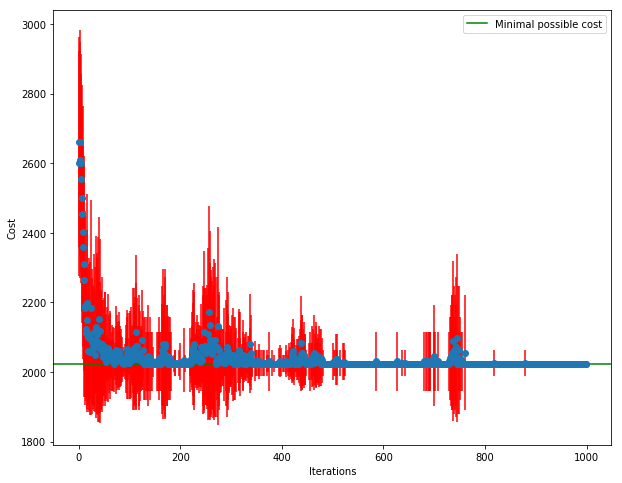

In [59]:
viz_convergence(results_opti[1], results_opti[2], min_cost(D_first))

On voit que cette méthode permet de converger mais est sujette à des déviations. Toutefois cette méthode peut avoir des difficultés à converger si on augmente la taille de la matrice : exemple ci dessous.

In [50]:
D = create_matrix(10)
%time results_opti=optimisation_mle(1000, 100, D, [0.1]*10, epsilon = 0.01)

Wall time: 2min 14s


In [51]:
m = min_cost(D)

In [52]:
min(results_opti[1]),m

(3078.925, 2733.0)

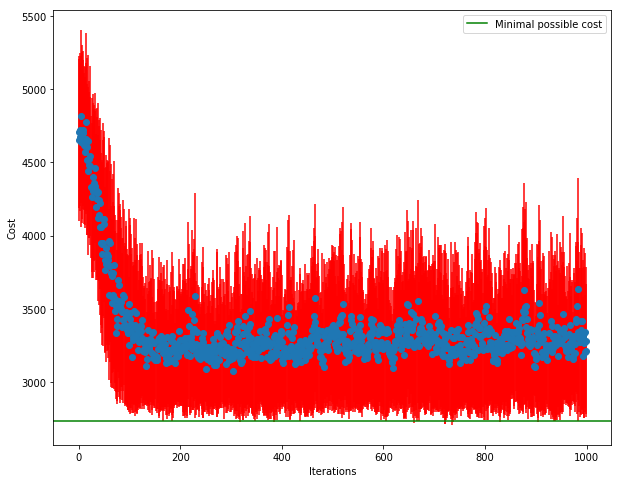

In [53]:
viz_convergence(results_opti[1], results_opti[2], m)

On remarque que cette méthode ne permet plus de converger dès que la matrice dépasse une certaine taille et ne présente donc pas un grand intérêt. La méthode suivante permet de résoudre des problèmes plus compliqués.

## 2.3 Deuxième méthode (inspirée du livre)

Cette méthode différe principalement de la première par la manière de générer les routes. On procède ici de la manière suivante : 

Soit une matrice de transition P (matrice dont les lignes somment à 1), on cherche à générer une permution de {1, $\dots$  ,n} comme suit : 


1. Poser $X_{1}=0, k=0, P^{1}=P$
2. Générer $P^{k+1}$ en remplaçant la $X_{k}$-ème colonne  par des zéros (on évite alors les passages d'une ville à elle même) 
Normaliser les lignes de la matrice pour qu'elles somment à 1. Générer $X_{k+1}$ suivant la distribution formée par la $X_{k}$-ème ligne de $P^{k+1}$
(En pratique on fait cela en tirant selon une multinomiale de paramètre la $X_{k}$-ème ligne de $P^{k+1}$ et 1, ce qui donne un vecteur dont toute les composantes sont nulles sauf une égale à 1, son indice donne alors la valeur de $X_{k+1}$ )
3. Stop si $k = n -1$, sinon $k=k+1$ et reprendre en 2



On commence par créer deux fonctions qui permettrons respectivement de générer une matrice de transition initale de taille m et de générer une route selon la procédure précédente étant donné une matrice P. Suivant les recommandations du livre et pour partir d'une distribution "uniforme", on génère cette matrice comme égale à 0 sur sa diagonale et $\frac{1}{m-1}$ partour ailleurs.




In [8]:
def unif_matrix(m):
    """m is an int
    Function returns a matrix of size (m,m) such that d[i,i]=0 and row sum = 1"""
    p = np.empty((m, m))
    p.fill(1 / (m - 1))
    for i in range(m):
        p[i,i] = 0
    return p


def generate_route_markov(P):
    """P : matrix 
    return permunation of [1,..,n]"""
    r = [0]
    city = [k for k in range(P.shape[0])]
    k = 0
    P2 = copy.deepcopy(P)
    while k < P.shape[0]-2:
        P2[:,r[k]] = 0
        for i in range(P2.shape[0]):
            P2[i,:] = P2[i,:]/sum(P2[i,:])
        r.append(multi(P2[r[k],:],1,1)[0][0].index(1))
        k += 1
    last = list(set(city) - set(r))
    r.append(last[0])
    return r

def diff_matrix(P1,P2):
    """P1 and P2 are matrix
    return sum of absolute difference"""
    d = abs(P1 - P2)
    return d.sum()


Puis on implémente l'optimisation : 

In [9]:
def count_bis(routes, i, j):
    """routes : matrix where each column is a route
    i : int which represents the city i
    j : int which represents the city j
    count how many roads go from i to j"""
    m = routes.shape[0]
    colonnes = [k for k in range(routes.shape[1])]
    routes = np.vstack((routes, routes[0,:]))
    c = 0
    for x in range(m):
        for y in colonnes:
            #print(x,y)
            if routes[x, y] == i:
                if routes[x+1, y] == j:
                    c += 1
                    colonnes.remove(y)
    return c

def iteration_markov(N, D, P_prev):
    """ Performs one iteration of mle "procedure" with markov chain technique to generate routes
    N is the number of multinomial simulated
    D is the distance matrix
    distri_prev is the previous distribution (ie parameters of the multinomial p1,p2..)
    
    Function return the MLE estimator of the parameters of the multinomial based on the 
    'best' 10% (cf chopin)"""
    P = copy.deepcopy(P_prev)
    m = P.shape[0]
    cache = []
    costs = []
    k = 0
    while k < N:
        try:
            r = generate_route_markov(P)
            cache.append(r)
            costs.append(cost(r,D))
            k += 1
        except:
            k = k
    idx = np.argpartition(np.array(costs), int(0.1*N))[:int(0.1*N)]
    select = np.array(cache[idx[0]]).reshape(-1,1)
    for i in idx[1:]:
        select = np.hstack((select, np.array(cache[i]).reshape(-1,1)))  
    prop = int(0.1*N)
    for i in range(m):
        for j in range(m):
            a = count_bis(select, i, j)
            if prop == 0 or a == 0:
                P[i,j] = 0.00001
            else:
                P[i,j] = a/prop
            
            if sum(P[i,:j]) == 0.999 and j < m - 1:
                P[i,j+1:] = 0.00001
                break
        P[i,:] = P[i,:]/sum(P[i,:])
    return P, np.mean(costs), np.std(costs)


def optimisation_markov(n, N, D, P_init, epsilon,t):
    """Performs at most n times the MLE iteration
    n : maximum number of iterations allowed
    N : Number of road generated
    D : cost matrix
    P_init : initial P
    epsilon : stopping criterio
    t : number of consecutive time where topping criterio is satisfied"""
    P_opti = copy.deepcopy(P_init)
    P_prev = np.zeros(P_opti.shape)
    cost_step = []
    std_step = []
    stag = [False for k in range(t+2)]
    k = 0
    while (k < n) and (sum(stag[-t:]) < t):
        k += 1
        it = iteration_markov(N , D, P_opti)
        stag.append((diff_matrix(P_opti, it[0]) <= epsilon))
        P_opti = it[0]
        cost_step.append(it[1])
        std_step.append(it[2])
    return P_opti, cost_step, std_step, stag

In [54]:
#On utilise la meme matrice D qu'avant
P = unif_matrix(10)
%time results_opti = optimisation_markov(150, 500, D, P, 0.005, 4)

Wall time: 1min 24s


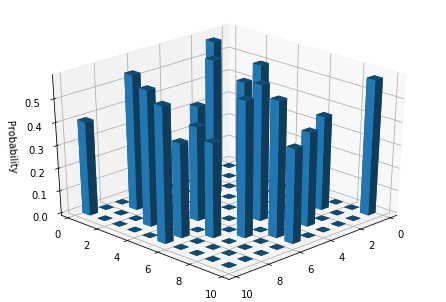

In [55]:
viz_matrix(results_opti[0])

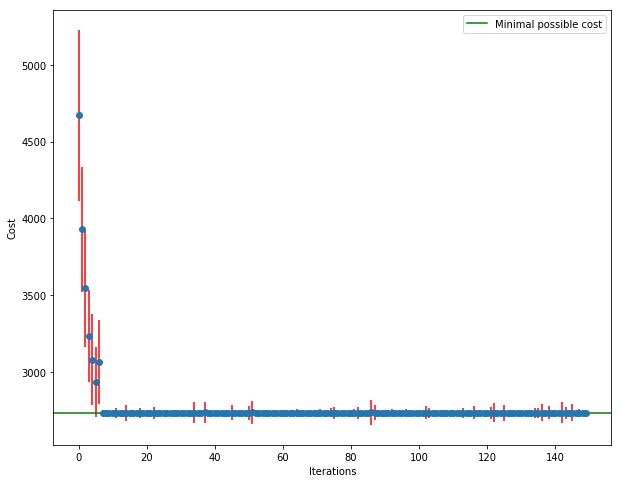

In [57]:
viz_convergence(results_opti[1],results_opti[2],m)

# 3. Question 3

*Question* : 

Concernant l’estimation bayésienne de vecteurs de probabilité d’une loi multinomiale,
retrouver le fait que la famille des lois de Dirichlet est conjuguée pour ce modèle. 
Expliquer comment en pratique vous pouvez utiliser cette propriété pour améliorer votre algorithme.

## 3.1 Démonstration
Nous avons démontré que la famille des lois de Dirichlet est conjuguée pour ce modèle.
En effet, si on prend comme a priori $P \sim  Dir\begin{pmatrix}
\alpha_{1}\\
... \\
\alpha_{M} \\
\end{pmatrix}$ alors la loi a posteriori s'écrit : 
\begin{equation*}
\Pi(p|X1,...,X_{M}) \propto \Pi(p)\Pi(X1,...,X_{M}|p) \\
\Longleftrightarrow \Pi(p|X1,...,X_{M}) \propto [\frac{1}{B(\alpha)}\prod_{i = 1}^{M}p_{i}^{\alpha_{i}-1}][\prod_{i = 1}^{n} \frac{(\sum_{j=1}^{M}X_{ij})!}{\sum_{j=1}^{M}X_{ij}!}\prod_{j=1}^{M}p_{j}^{X_{ij}}]  \\
\Longleftrightarrow \Pi(p|X1,...,X_{M}) \propto \prod_{j=1}^{M}p_{j}^{\alpha_{i} + \sum_{i = 1}^{n}X_{ij} - 1}  
\end{equation*} \\
Ainsi, nous pouvons dire que $P|X1,...,X_{M} \sim Dir\begin{pmatrix}
\alpha_{1} + \sum_{i = 1}^{n}X_{i1} \\
... \\
\alpha_{M} + \sum_{i = 1}^{n}X_{iM} \\
\end{pmatrix} $

## 3.2 Deuxième méthode améliorée avec Bayes

Ici, nous utilisons la propriété de conjugaison de la loi de Dirichlet par rapport à la Multinomiale pour essayer d'améliorer notre algorithme basé sur les chaînes de Markov. Cette méthode permet de ne pas avoir de 0 sur les lignes de la matrice (nous avions réglé ce problème avec la méthode précédente en remplaçant les 0 par des valeurs numériquement très petites.)

Dans la première partie, nous cherchions à actualiser directement les éléments de notre matrice de passage P, ici nous allons poser une distribution de Dirichlet a priori sur chaque ligne de la matrice P. 

Si on pose $P = (p_{ij})_{i,j \in [1, \dots, M]}$ alors on supposera que $(p_{i1}, \dots, p_{iM}) \sim Dirichlet(\alpha_{i1}, \dots, \alpha_{iM})$ . 

Chaque ligne la matrice suivant une Dirichlet distincte, le problème consiste maintenant à trouver les paramètres des dirichlets qui permettront de simuler les lignes optimales.

Notre paramètre d'intérêt étant maintenant les M vecteurs $(\alpha_{i1}, \dots, \alpha_{iM})_{i \in [1, \dots, M]}$. Nous commençons par stocker ces paramètres sous forme de matrice $\Gamma$ de taille $M \times M$, nous codons aussi une fonction permettant de générer une matrice P de passage étant donné $\Gamma$.


De façon à générer une matrice P de départ "uniforme", on initialise $\Gamma$ à une matrice dont tous les coefficients sont égaux à 1 sauf la diagonale qui est nulle. 


*En pratique, on met les éléments de la diagonale très petit mais pas nuls strictement pour éviter des problèmes numérique dans la génération de multinomiales.*

In [58]:
def create_alpha(m):
    """Return a matrix wwhere each row corresponds to the parameters of the Dirichlet law
    m : size of matrix"""
    return (np.ones((m,m)) - 0.99999*np.eye(m))

def generate_p(alphas):
    """alpha : matrix of shape (m,m)
    return a matrix of shape (m,m) where row i is realization of the dirichlet of parameters alpha[i,:]"""
    m = alphas.shape[0]
    p = np.random.dirichlet(alphas[0,:])
    for i in range(1,m):
        pn = np.random.dirichlet(alphas[i,:])
        p = np.vstack((p, pn))
    return p

D'après les calculs présentés en section précédente, on peut donc définir la procédure d'actualisation de $\Gamma$ suivante : 

1. On génère les routes comme précédemment et on garde les routes faisant parti des 10% meilleures.
2. On actualise $\alpha_{ij} = \alpha_{ij} + x_{ij} $ où $x_{ij}$ est le nombre de chemin où le passage $i \sim j$ existe. 




In [62]:
def iteration_baye_markov(N, D, P_prev, alphas_prev):
    """ Performs one iteration of mle "procedure" with markov chain technique to generate routes
    N : Number of maximal iterations
    D is the distance matrix
    distri_prev is the previous distribution (ie parameters of the multinomial p1,p2..)
    alphas_prev : matrix of size (m,m) which represents the previous alpha matrix
    Function return the MLE estimator of the parameters of the multinomial based on the 
    'best' 10% (cf chopin)"""
    alphas = copy.deepcopy(alphas_prev)
    m = alphas_prev.shape[0]
    cache = []
    costs = []
    k = 0
    while k < N:
        try:
            r = generate_route_markov(P_prev)
            cache.append(r)
            costs.append(cost(r,D))
            k += 1
        except:
            k = k
    idx = np.argpartition(np.array(costs), int(0.1*N))[:int(0.1*N)]
    select = np.array(cache[idx[0]]).reshape(-1,1)
    for i in idx[1:]:
        select = np.hstack((select, np.array(cache[i]).reshape(-1,1)))    
    for i in range(m):
        for j in range(m):
            if i != j:
                a = count_bis(select,i,j)
                alphas[i,j] += a
    P = generate_p(alphas)
    return P, alphas, np.mean(costs), np.std(costs)


def optimisation_markov_baye(n, N, D, alphas_init):
    """Performs n times the MLE iteration
    n : number of maximal iterations
    N : number of roads generated
    D : cost matrix
    alphas_init : initial alpha parameter"""
    P_init = generate_p(alphas_init)
    P_opti = copy.deepcopy(P_init)
    alphas_opti = alphas_init.copy()
    cost_step = []
    std_step=[]
    for k in range(n):
        it = iteration_baye_markov(N, D, P_opti, alphas_opti)
        P_opti = it[0]
        alphas_opti = it[1]
        cost_step.append(it[2])
        std_step.append(it[3])
    return P_opti, alphas_opti, cost_step, std_step

In [63]:
D = create_matrix(8)
m = min_cost(D)
alphas = create_alpha(8)
%time results_opti = optimisation_markov_baye(150, 500, D, alphas)

Wall time: 48.5 s


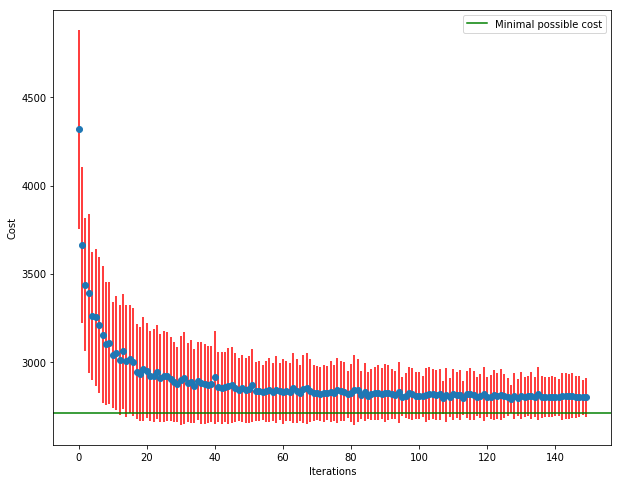

In [64]:
viz_convergence(results_opti[2],results_opti[3], m)

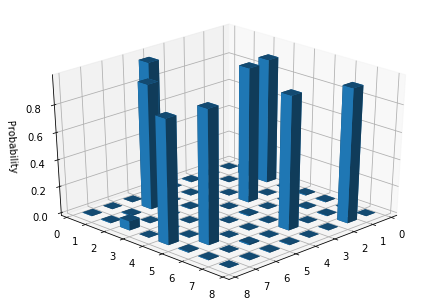

In [65]:
viz_matrix(results_opti[0])

# 4. Question 4

*Question* :

Bonus: en fonction du temps disponible, vous pouvez tester votre algorithme sur de “gros” problèmes (par ex. trajet optimal du tour de France en se basant sur la liste des villes de l’année dernière), ou comparer à d’autres algorithmes que vous trouverez dans la littérature.


## 4.1 Application à un "gros" problème

D'abord quelques problème un peu plus gros dont la solution théorique est connue, nous avons récupérer ces données ici : https://people.sc.fsu.edu/~jburkardt/datasets/tsp/tsp.html. 
On va tester notre méthode sur 3 problèmes à 26, 42 et 48 villes dont les coûts théorique minimums sont respectivement 937, 699 et 10628.  

In [66]:
P = unif_matrix(26)
%time results_opti_markov = optimisation_markov(150, 500, big_937, P, 0.1, 4)

Wall time: 2min 2s


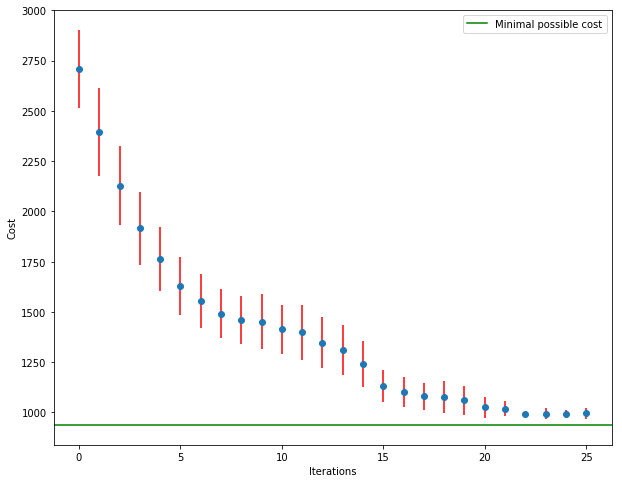

In [67]:
viz_convergence(results_opti_markov[1], results_opti_markov[2], 937)

On constate une convergence vers la bonne solution plutôt rapidement, mais avec un fort écart-type. Le fort ecart type est certainement . (faire avec un algo de benchmark)

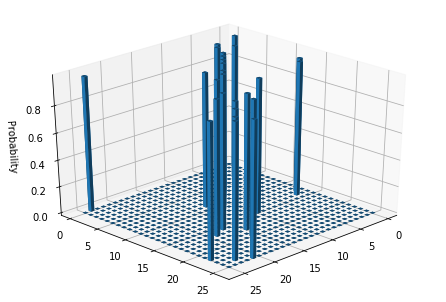

In [68]:
viz_matrix(results_opti_markov[0])

In [70]:
print("Cout final moyen :" + str(results_opti_markov[1][-1]))

Cout final moyen :994.508


In [9]:
P = unif_matrix(42)
%time results_opti_markov = optimisation_markov(150, 500, big_699, P, 0.1, 4)

Wall time: 10min 35s


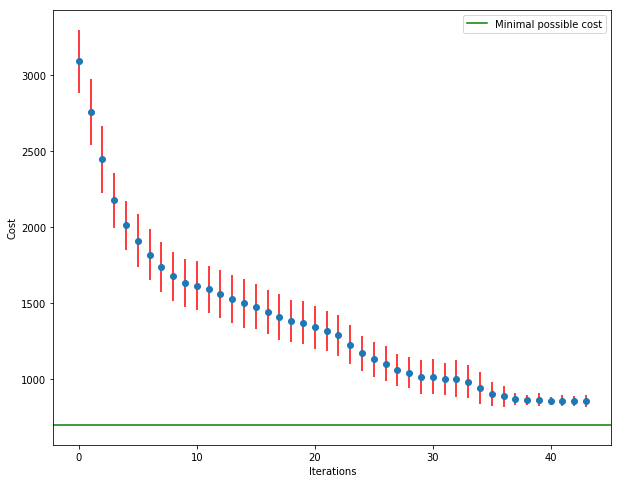

In [10]:
viz_convergence(results_opti_markov[1],results_opti_markov[2],699)

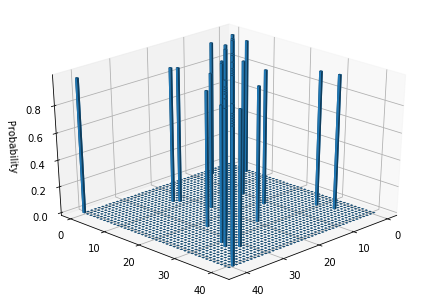

In [11]:
viz_matrix(results_opti_markov[0])

In [12]:
print("Cout final moyen :" + str(results_opti_markov[1][-1]))

Cout final moyen :858.442


Pour celle-ci on observe une convergence vers un coût presque minimal en un temps convenable.



In [13]:
P = unif_matrix(48)
%time results_opti_markov = optimisation_markov(200, 500, big_10628, P, 0.1, 4)

Wall time: 16min 15s


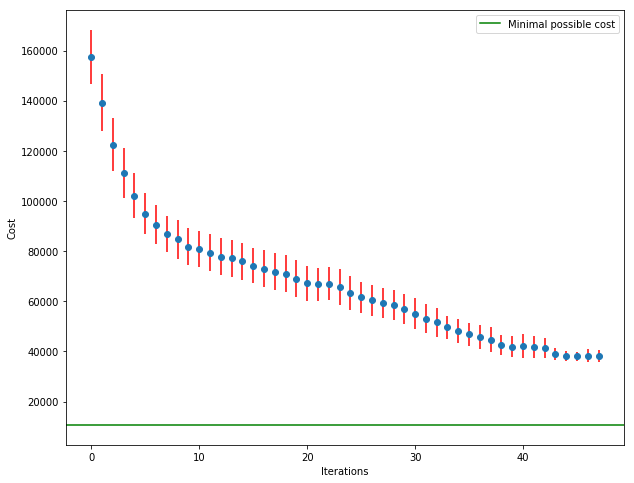

In [14]:
viz_convergence(results_opti_markov[1], results_opti_markov[2], 10628)

Enfin, pour ce problème, notre méthode converge mais vers une solution sous optimale

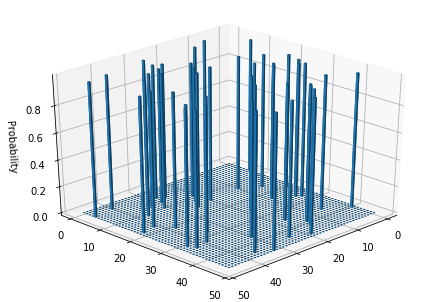

In [15]:
viz_matrix(results_opti_markov[0])

In [16]:
print("Cout final moyen :" + str(results_opti_markov[1][-1]))

Cout final moyen :38141.458


**Passons maintenant à un autre problème dont la solution est inconnue**

Nous avons considéré les villes présentes dans l'édition prochaine du Tour de France (Juillet 2019). En utilisant les deux méthodes précedemment développées, nous allons rechercher quel est le chemin optimal pour parcourir ces 34 villes.

In [10]:
#Generation data
def matrix_cities(list_cities, list_coor):
    """list_cities : array with names of cities
    list_coor : array with coordinates associated to each city
    Return a matrix of cost"""
    matrix = pd.DataFrame()
    for city in range(len(list_coor)) :
        dist_city = [0]*(city+1)
        for coor in range(city+1, len(list_coor)):
            dist = (geodesic(list_coor[city], list_coor[coor]).miles)*1.60934
            dist_city.append(dist)
        matrix[list_cities[city]] = dist_city
    return(matrix.values.transpose() + matrix.values)
  
list_cities = ['Bruxelles',  'Binche', 'Epernay', 'Reims', 'Nancy', 'Saint-Dié-des-Vosges' , 
             'Colmar', 'Mulhouse', 
             'Planche des belles filles','Belfort', 'Châlon-sur-Saône', 'Mâcon', 'Saint-Etienne',  
             'Brioude', 
             'Saint-Flour', 'Albi', 'Toulouse', 'Bagnères-de-Bigorre','Pau', 'Tarbes', 
             'Col du Tourmalet', 
             'Limoux', 'Foix', 'Nîmes', 'Pont du Gard', 'Gap', 'Embrun', 'Valloire', 
             'Saint-Jean-de-Maurienne',
             'Tignes', 'Albertville', 'Val-Thorens', 'Rambouillet', 'Paris']

list_coor = [(50.8504500,4.3487800), (50.4,4.1667), (49.05,3.95), (49.25,4.0333), (48.6833,6.2),
          (48.2833, 6.95), (48.0833,7.3667), (47.75,7.3333), (47.6333,6.8667),
           (47.77221424587152,6.7775774002075195), (46.780764,4.853947), (46.3,4.8333),
          (45.439695,4.3871779), (45.3,3.4), (45.0333,3.0833), (43.9333,2.15), (43.6043,1.4437),
          (43.0667,0.15), (43.3,-0.3667), (43.2333,0.0833), (42.908963,0.145375),
           (43.0667,2.2333), (42.9667,1.6), (43.8333,4.35), (43.947567,4.53496),
          (44.5667,6.0833), (44.5639, 6.4953), (45.165001,6.4262), (45.2833,6.35),
          (45.5 ,6.9167), (45.6745,6.3906), (45.2977700,6.5837700), (48.65,1.8333),
           (48.8534, 2.3488)]

matrix_tour_france = matrix_cities(list_cities, list_coor)

In [14]:
##initialization
P = unif_matrix(matrix_tour_france.shape[0])

In [17]:
%time results_opti_markov = optimisation_markov(50, 500, matrix_tour_france, P, 0.1, 4)

Wall time: 6min 31s


No handles with labels found to put in legend.


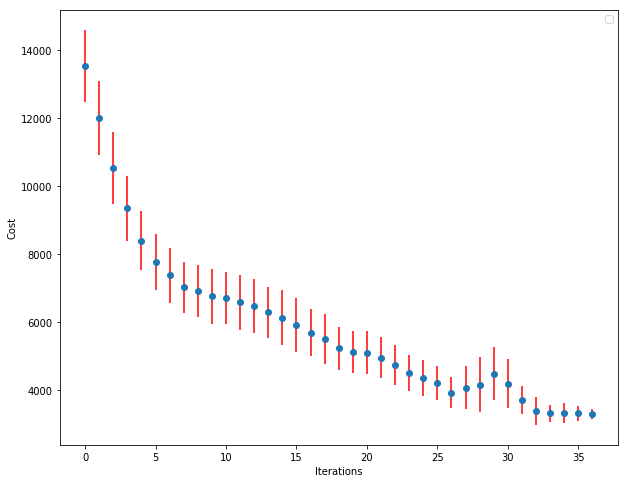

In [19]:
viz_convergence(results_opti_markov[1],results_opti_markov[2])

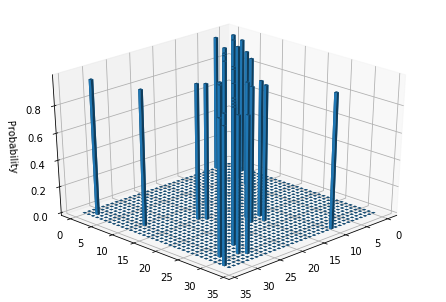

In [20]:
viz_matrix(results_opti_markov[0])

In [21]:
print("Cout final moyen :" + str(results_opti_markov[1][-1]))

Cout final moyen :3306.1015688741877


Comme nous pouvions nous y attendre, nous obtenons les même résultats pour les deux méthodes. La deuxème méthode est cependant plus rapide ( contre ). Le chemin renvoyé est : 

In [0]:
#Corresponding route 
route  = generate_route_markov(results_opti_markov[0])

## 4.2 Comparaison avec d'autres méthodes

## 4.2.1 Comparaison avec le package solve_tsp

Lien Github de la méthode utilisée : https://github.com/dmishin/tsp-solver 

Nous avons voulu ici comparer notre algorithme au package solve_tsp qui est disponible sur pypi. Ceci nous permet d'obtenir un benchmark rapidement utilisable

Ce package semble appliquer un algorithme "greedy" - "nearest neighbour". La logique d'un tel algorithme est la suivante : 

1) Au début, chaque ville représente un morceau de trajet ou segment (du coup égaux à un point).

2) Chercher les deux segments les plus proches et les connecter

3) Répéter 2) jusqu'à ce qu'il n'y ait que 2 segments

4) Reprendre à 1) avec un nouveau point de départ 

5) Répéter 1-4) jusqu'à avoir exploré toutes les possibilités

6) Sélectionner le chemin avec le coût le plus petit


En lisant les critiques de ce package sur internet, nous avons constaté que son output est sensible au point de d'arrivée. De ce fait, nous l'avons incorperé à notre propre fonction afin qu'il explore toute les possibilités. Nous comparerons le temps de cette fonction au temps de notre algorithme initial. 
Pour avoir une idée de l'influence de ce paramètre, nous calculons aussi l'écart type des couts engendrés

In [51]:
big_937.shape,big_699.shape,big_10628.shape

((26, 26), (42, 42), (48, 48))

In [25]:
def find_min_solver(matrix):
    """Function to find the min cost of a matrix
    matrix : the matrix to explore"""
    cout = []
    n = len(matrix)
    for i in range(0,n):
        for j in range(0,i):
            path = solve_tsp(matrix, endpoints = (i,j))
            cout.append(cost(path, matrix))  
    return min(cout), np.std(cout)

In [29]:
#Problème à 42 villes dont la solution est 937

%time find_min_solver(big_937)

Wall time: 574 ms


(961.0, 67.93960422673368)

In [124]:
#Problème à 42 villes dont la solution est 699

%time find_min_solver(big_699)

Wall time: 7.01 s


(721.0, 40.0034730747207)

In [122]:
#Problème à 48 villes dont la solution est 10628

%time find_min_solver(big_10628)

Wall time: 13.1 s


(34357.0, 1712.2817322185565)

In [126]:
#Problème à 34 villes dont la solution est inconnue

%time find_min_solver(matrix_tour_france)

Wall time: 3.06 s


(2819.481786854192, 208.77213245073173)

Nous pouvons donc conclure que ce package est beaucoup plus rapide et donne des coûts plus faibles. De plus, dans le cas de grosses matrices, ce package ne semble pas converger.

## 4.2.2 Comparaison avec le simulated annealing

La logique du simulated annealing constitue une solution pertinente pour le problème Travelling Salesman. 
Le fait que l'algorithme autorise temporairement des solutions non optimales pour explorer d'autres possibilités et éviter de converger vers un minimum local apparait logique. Plus la température (T) est élevée, plus l'algorithme est autorisé à accepter des solutions sous-optimales pour parcourir l'ensmeble des possibilités. La probabilité d'accepter une solution voisine est : $P(Accepter) = exp((SolutionEnergy - NeighbourEnergy)/T)$

Nous présentons rapidement la logique de cette algorithme.

- Définir une température et un chemin initiale de départ de façon aléatoire
- Tant queT < seuil ou autre condition particulière :
        - On teste une possibilité voisine
        - On estime la probabilité pour savoir si on change
        - La température diminue ("Slowly cool")

Lien de la page : https://github.com/JeromeBau/TravelingTouristProblem 

Nous souhaitons ici comparer notre méthode à un algorithme connu comme le simulated annealing sur le problème de parcourir des villes européennes en minimisant le coût (ici les km parcourus). La solution optimale pour la base europe utilisée est de 12152,27 pour le simulated annealing étudié sur Github.

In [57]:
class TravelingTourist(object):
    """" Applies Simulated Annealing to a traveling salesman problem"""
    def __init__(self):
        self.temperature_initial = 1
        self.temperature_terminal = 0.0001
        self.cooling_rate = 0.99
        self.X = None
        self.y = None
        self.trip = None
        self.trip_neighbor = None
        self.state_evolution = []
        self.distances = None
        self.latlong = None

    def define_problem(self, cities, round_trip=True, shuffle=False):
        """ Define the problem
        :param cities: A list of city names as strings
        :param round_trip: True if Start==End
        :param shuffle: choose a random permutation
        """
        if round_trip:
            self.trip = cities
            if shuffle:
                random.shuffle(self.trip)

    @staticmethod
    def retrieve_latlong_for_city(city):
        """ Retrieve the distances for all given cities
        Output as matrix
        """
        geolocator = Nominatim()
        c = geolocator.geocode(city)
        return [c.longitude, c.latitude]

    def retrieve_distance_between_cities(self, city1, city2, unit='km'):
        geolocator = Nominatim()
        c1 = geolocator.geocode(city1)
        c2 = geolocator.geocode(city2)
        if unit == 'km':
            return vincenty(c1.point, c2.point).km
        if unit == 'miles':
            return vincenty(c1.point, c2.point).miles

    def make_latlong(self, load_from_file=None):
        """ Generate a data frame containing the previously defined cities with their respective longitude
        and latitude
        """
        if load_from_file:
            self.distances = pd.read_csv(load_from_file,";", index_col=0)
        else:
            assert self.trip is not None, 'The problem has not been defined. Run define_problem().'
            latlong = pd.DataFrame(self.trip)
            latlong[1] = latlong[0].apply(t.retrieve_latlong_for_city)
            latlong[['Longitude', 'Latitude']] = pd.DataFrame([x for x in latlong[1]])
            latlong.index = latlong[0]
            del latlong[0]
            del latlong[1]
            self.latlong = latlong

    def make_distances(self, load_from_file=None):
        if load_from_file:
            self.distances = pd.read_csv(load_from_file,";", index_col=0)
        else:
            assert self.trip is not None, 'The problem has not been defined. Run define_problem().'
            distances = pd.DataFrame(np.zeros([len(self.trip), len(self.trip)]))
            distances = distances.replace(0, -1)
            distances.columns = self.trip
            distances.index = self.trip
            self.distances = distances
            for city in self.trip:
                self.distances.loc[city].loc[city] = 0
            for city_tuple in itertools.combinations(self.trip, 2):
                logging.debug(city_tuple)
                if self.distances.loc[city_tuple[0]].loc[city_tuple[1]] < 0 \
                        or self.distances.loc[city_tuple[1]].loc[city_tuple[0]] < 0:
                    try:
                        dist = self.retrieve_distance_between_cities(city_tuple[0], city_tuple[1])
                    except GeocoderUnavailable:
                        logging.warning('Geopy Geocoder was not available.')
                        dist = np.nan
                    except HTTPError:
                        logging.warning('Too many requests for Geopy. Waiting a few seconds')
                        time.sleep(30)
                        dist = np.nan
                    self.distances.loc[city_tuple[0]].loc[city_tuple[1]] = dist
                    self.distances.loc[city_tuple[1]].loc[city_tuple[0]] = dist

    def energy(self, trip):
        return self.journey_distance(trip)

    def journey_distance(self, trip, round_trip=True):
        assert self.distances is not None, 'No distance matrix loaded'
        distances = []
        if round_trip:
            for i in range(len(trip)-1):
              #ERROR NEXT LINE
                distances.append(self.distances.loc[trip[i]].loc[trip[i+1]])
            #distances.append(self.distances.loc[trip[len(trip)-1]].loc[trip[0]])
        return np.array(distances).sum()

    @staticmethod
    def acceptance_probability(energy_old, energy_new, T):
        """ Compare energy states with respect to current temperature"""
        return np.exp((energy_old-energy_new)/T)

    def generate_neighbor(self):
        """ Switch two random cities"""
        trip_neighbor = self.trip.copy()
        sw = random.sample(range(len(self.trip)), 2)
        trip_neighbor[sw[1]], trip_neighbor[sw[0]] = trip_neighbor[sw[0]], trip_neighbor[sw[1]]
        self.trip_neighbor = trip_neighbor

    def anneal(self):
        """ Simulated Annealing
        Work through the classical process of
        """
        assert self.distances is not None, 'No distance file present'
        assert self.trip is not None, 'No problem was defined. Run self.define_problem().'
        self.state_evolution.append(self.trip)  # state_evolution only serves to follow up on the states chosen
        T = self.temperature_initial
        while T > self.temperature_terminal:
            for n in range(len(self.trip)):
                self.generate_neighbor()
                energy_old = self.energy(self.trip)
                energy_new = self.energy(self.trip_neighbor)
                if self.acceptance_probability(energy_old, energy_new, T) > random.random():
                    self.trip = self.trip_neighbor  # the alternative state was accepted
                    self.state_evolution.append(self.trip)
            T *= self.cooling_rate
        return self.trip
    

In [58]:
t = TravelingTourist()
t.define_problem(['Belgrade', 'Berlin', 'Brussels', 'Bucharest', 'Budapest', 'Copenhagen', 'Dublin',  'Paris', 'Lisbon', 'Madrid', 'Cologne', 'Bern', 'Amsterdam', 'London', 'Manchester', 'Oslo', 'Rome', 'Sicily', 'Montpellier', 'Zurich', 'Vienna', 'Athina'])

In [59]:
t.make_distances(load_from_file='distances_matrix.csv')
#t.make_latlong(load_from_file='latlong_matrix.csv')

In [60]:
%time t.anneal()

Wall time: 1min 55s


['Cologne',
 'Zurich',
 'Vienna',
 'Budapest',
 'Berlin',
 'Copenhagen',
 'Oslo',
 'Dublin',
 'Lisbon',
 'Madrid',
 'Montpellier',
 'Brussels',
 'Amsterdam',
 'Manchester',
 'London',
 'Paris',
 'Bern',
 'Rome',
 'Sicily',
 'Athina',
 'Bucharest',
 'Belgrade']

In [62]:
route_anneal = t.trip

In [61]:
len(t.trip),europe.shape

(22, (23, 23))

In [63]:
t.journey_distance(route_anneal)

12629.102381229302

In [22]:
europe = pd.read_csv('distances_matrix.csv',';', index_col = 0)
europe = pd.DataFrame.as_matrix(europe)

C:\Users\mehdi\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [32]:
%time find_min_solver(europe)

Wall time: 420 ms


(11163.475740829244, 800.3140253860134)

In [46]:
##initialization
P = unif_matrix(europe.shape[0])

In [47]:
%time results_opti_markov = optimisation_markov(100, 500, europe, P, 0.1, 4)

Wall time: 1min 28s


No handles with labels found to put in legend.


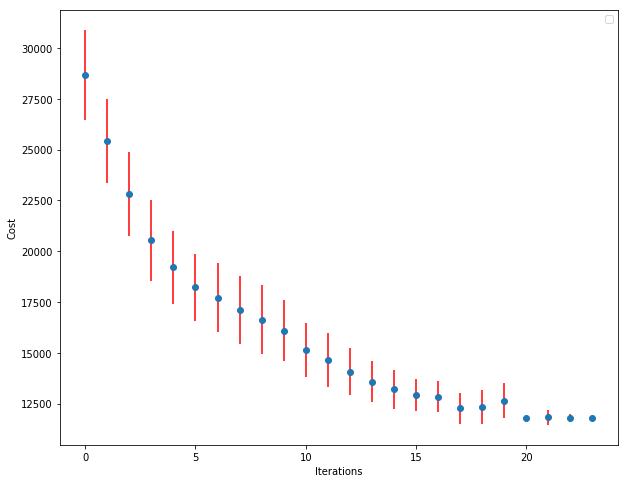

In [52]:
viz_convergence(results_opti_markov[1],results_opti_markov[2])

In [53]:
print("Cout final moyen :" + str(results_opti_markov[1][-1]))

Cout final moyen :11784.963881805537


## Comparaison des résultats - Récapitulatif 

In [68]:
arrays = [['26 villes', '26 villes', '26 villes', '42 villes', '42 villes', '42 villes', '48 villes', '48 villes','48 villes',"Tour de france 34 villes","Tour de france 34 villes","Tour de france 34 villes",'Europe - 22 villes','Europe - 22 villes','Europe - 22 villes'],
          ['Cout', 'Cout_theorique', 'Temps (s)', 'Cout', 'Cout_theorique', 'Temps (s)', 'Cout', 'Cout_theorique', 'Temps (s)','Cout', 'Cout_theorique', 'Temps (s)','Cout', 'Cout_theorique', 'Temps (s)']]

In [67]:
results = [[994.5,961,],
           [937,937,937],
           [122,0.8,],
           [858,721,],
           [699,699,699],
           [635,7,],
           [38141,34357,],
           [10628,10628,10628],
           [960,13,],
           [3306,2819,np.nan],
           [np.nan,np.nan,np.nan],
           [360,3,np.nan],
           [11784,11163,12669],
           [np.nan,np.nan,np.nan],
           [88,0.42,115]]

In [69]:
comparaison = pd.DataFrame(results, index=arrays, columns= ["Markov - Notre modele","Greedy method","Annealling"])

In [70]:
comparaison

Markov - Notre modele  Greedy method  \
26 villes                Cout                            994.5         961.00   
                         Cout_theorique                  937.0         937.00   
                         Temps (s)                       122.0           0.80   
42 villes                Cout                            858.0         721.00   
                         Cout_theorique                  699.0         699.00   
                         Temps (s)                       635.0           7.00   
48 villes                Cout                          38141.0       34357.00   
                         Cout_theorique                10628.0       10628.00   
                         Temps (s)                       960.0          13.00   
Tour de france 34 villes Cout                           3306.0        2819.00   
                         Cout_theorique                    NaN            NaN   
                         Temps (s)                       360.0           3.00   
Europe - 22 villes       Cout                          11784.0       11163.00   
                         Cout_theorique                    NaN            NaN   
                         Temps (s)                        88.0           0.42   

                                         Annealling  
26 villes                Cout                   NaN  
                         Cout_theorique       937.0  
                         Temps (s)              NaN  
42 villes                Cout                   NaN  
                         Cout_theorique       699.0  
                         Temps (s)              NaN  
48 villes                Cout                   NaN  
                         Cout_theorique     10628.0  
                         Temps (s)              NaN  
Tour de france 34 villes Cout                   NaN  
                         Cout_theorique         NaN  
                         Temps (s)              NaN  
Europe - 22 villes       Cout               12669.0  
                         Cout_theorique         NaN  
                         Temps (s)            115.0